### Preprocessing

In [1127]:
import pandas as pd
import re
import matplotlib.pyplot as plt

df1 = pd.read_csv('movies_kaggle_dataset.txt',sep=":::", header=None, index_col=0)
df1.columns = ['Title','Genre','Plot']
df1.Title = df1.Title.apply(lambda x: re.sub("\(.*\)", "", x).replace("\"", "").strip())
df1.Genre = df1.Genre.apply(lambda x: x.strip().title())

df2 = pd.read_csv('movie_plots_yts.csv',index_col=0)
df2.Plot = df2.Plot.apply(lambda x: re.sub("\\x97.*" , "", x).rstrip())
df2.columns = ['Title','Plot','Genre']

C:\Users\Jacopo\anaconda3\envs\tf-gpu\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [1128]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)

In [1129]:
df1.head()

,Title,Genre,Plot
0,,,
1,Oscar et la dame rose,Drama,Listening in to a conversation between his do...
2,Cupid,Thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful",Adult,As the bus empties the students for their fie...
4,The Secret Sin,Drama,To help their unemployed father make ends mee...
5,The Unrecovered,Drama,The film's title refers not only to the un-re...


In [1130]:
df2.head()

,Title,Plot,Genre
0,Who is Amos Otis?,"After assassinating the President, Amos Otis p...",Drama
1,Wheel of Time,Wheel of Time is Werner Herzog's photographed ...,Documentary
3,'B' Girl Rhapsody,Burlesque beauties performing their signature ...,Drama
5,The Brass Bottle,After being released from his bottle by Harold...,"Comedy, Fantasy"
6,The Morning After,The Morning After is a feature film that consi...,"Comedy, Drama"


In [1131]:
df1.Plot.values[2901], df2.Plot.values[2901]

(' Two people struggle to find meaning in their otherwise deceptively empty lives. Milly and Jean are two old friends who reunite with pleasantries, tea, and biscuits. Soon they reveal their dissatisfaction with the world to one another, but will their connection be enough to pull them through?',
 'This feature documentary tells the inside story behind the hunt for ISIS poster boy "Jihadi John" by the US and British military and intelligence services. It interrogates the twisted worldview espoused by ISIS - the richest and most notorious Islamist terrorist organisation in history - and its propaganda machine which was operated by "Jihadi millennials" who turned social media sites such as Twitter and YouTube into recruitment platforms. This is the definitive story about the formation and collapse of ISIS as a "state", told through extraordinary first-hand accounts of key counter-terrorism and intelligence officials who identified "Jihadi John" as British terrorist Mohammed Emwazi - and 

In [1132]:
df_final = pd.concat([df1,df2]).drop_duplicates("Title")

In [1133]:
print(df_final.shape)
#cleaning on plot
searchfor = [' sa ', ' la ', ' est ', ' il ', ' chi ', ' è ', ' ist ', ' y ', ' und ', 'capítulo', 'tiempo', ' for translation', ' og ', ' ein ', ' pas ', ' er ', 'WWF', 'WWE','Wrestling', ' dans ']
df_final = df_final[~df_final.Plot.str.contains('|'.join(searchfor))]

#cleaning on genre
df_final = df_final[~df_final.Genre.str.contains("Tv|Show|News")]

print(df_final.shape)

(81487, 3)
(79218, 3)


In [1134]:
df = df_final[df_final.Plot.str.len() >300]
print(df.shape)
df.head()

(58141, 3)


,Title,Genre,Plot
1,Oscar et la dame rose,Drama,Listening in to a conversation between his do...
3,"Young, Wild and Wonderful",Adult,As the bus empties the students for their fie...
4,The Secret Sin,Drama,To help their unemployed father make ends mee...
5,The Unrecovered,Drama,The film's title refers not only to the un-re...
6,Quality Control,Documentary,Quality Control consists of a series of 16mm ...


In [1187]:
df['Plot'] = df['Plot'].apply(lambda x : re.sub("\(.*\)", "") )

"'Hadji Cheriff'  studio. He has a large knife in his hand at the opening of the act. He then hurls the knife away and begins a rapid series of dance-like motions, executing numerous cartwheels and whirling movements."

### Doc embeddings

In [1135]:
from gensim.models.doc2vec import TaggedDocument

data = list()
for row in df.iterrows():
    title = row[1][0]
    plot = row[1][2]
    genre = row[1][1].replace(" ","").lower().split(",")
    title_doc = title.lower().split(" ")
    tagged_doc = re.split('[\W\d_]+', plot.lower())
    #tagged_doc.extend(genre)
    #tagged_doc.extend(title_doc)
    tagged_doc = [w for w in tagged_doc if w != '']
    
    data.append(TaggedDocument(tagged_doc,[title]))
    
    
data[1]

TaggedDocument(words=['as', 'the', 'bus', 'empties', 'the', 'students', 'for', 'their', 'field', 'trip', 'to', 'the', 'museum', 'of', 'natural', 'history', 'little', 'does', 'the', 'tour', 'guide', 'suspect', 'that', 'the', 'students', 'are', 'there', 'for', 'more', 'than', 'just', 'another', 'tour', 'first', 'during', 'the', 'lecture', 'films', 'the', 'coeds', 'drift', 'into', 'dreams', 'of', 'the', 'most', 'erotic', 'fantasies', 'one', 'can', 'imagine', 'after', 'the', 'films', 'they', 'release', 'the', 'emotion', 'of', 'the', 'fantasies', 'in', 'the', 'most', 'erotic', 'and', 'uncommon', 'ways', 'one', 'slips', 'off', 'to', 'the', 'curator', 's', 'office', 'for', 'a', 'little', 'acquisition', 'another', 'finds', 'the', 'anthropologist', 'to', 'see', 'what', 'bones', 'can', 'be', 'identified', 'even', 'the', 'head', 'teacher', 'isn', 't', 'immune', 'soon', 'the', 'tour', 'is', 'over', 'but', 'as', 'the', 'bus', 'departs', 'everyone', 'admits', 'it', 'was', 'quite', 'an', 'education']

In [1136]:
import logging
import multiprocessing
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
cores = multiprocessing.cpu_count()
cores

12

In [1137]:
from gensim.models import Doc2Vec
model = Doc2Vec(data, vector_size=200, window=8, min_count=7, epochs=20, workers=cores)

2022-01-08 11:48:06,229 : INFO : collecting all words and their counts
2022-01-08 11:48:06,230 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2022-01-08 11:48:06,531 : INFO : PROGRESS: at example #10000, processed 1188039 words (3947975/s), 49573 word types, 10000 tags
2022-01-08 11:48:23,958 : INFO : PROGRESS: at example #20000, processed 2369294 words (67784/s), 70249 word types, 20000 tags
2022-01-08 11:48:24,262 : INFO : PROGRESS: at example #30000, processed 3534603 words (3881691/s), 86185 word types, 30000 tags
2022-01-08 11:48:24,579 : INFO : PROGRESS: at example #40000, processed 4709764 words (3720160/s), 100185 word types, 40000 tags
2022-01-08 11:48:24,885 : INFO : PROGRESS: at example #50000, processed 5823920 words (3658112/s), 111050 word types, 50000 tags
2022-01-08 11:48:25,585 : INFO : collected 118324 word types and 58141 unique tags from a corpus of 58141 examples and 6745267 words
2022-01-08 11:48:25,586 : INFO : Creating a fresh vo

2022-01-08 11:48:54,438 : INFO : EPOCH 3 - PROGRESS: at 80.93% examples, 500767 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:48:55,458 : INFO : EPOCH 3 - PROGRESS: at 91.43% examples, 500647 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:48:56,143 : INFO : worker thread finished; awaiting finish of 11 more threads
2022-01-08 11:48:56,147 : INFO : worker thread finished; awaiting finish of 10 more threads
2022-01-08 11:48:56,167 : INFO : worker thread finished; awaiting finish of 9 more threads
2022-01-08 11:48:56,175 : INFO : worker thread finished; awaiting finish of 8 more threads
2022-01-08 11:48:56,191 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-01-08 11:48:56,201 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-01-08 11:48:56,212 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-01-08 11:48:56,228 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-01-08 11:48:56,232 : INFO : worker th

2022-01-08 11:49:27,052 : INFO : EPOCH 7 - PROGRESS: at 9.96% examples, 510316 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:49:28,071 : INFO : EPOCH 7 - PROGRESS: at 19.61% examples, 493516 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:49:29,078 : INFO : EPOCH 7 - PROGRESS: at 30.06% examples, 506196 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:49:30,098 : INFO : EPOCH 7 - PROGRESS: at 40.47% examples, 509492 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:49:31,111 : INFO : EPOCH 7 - PROGRESS: at 51.22% examples, 513757 words/s, in_qsize 24, out_qsize 0
2022-01-08 11:49:32,127 : INFO : EPOCH 7 - PROGRESS: at 61.93% examples, 517463 words/s, in_qsize 24, out_qsize 0
2022-01-08 11:49:33,138 : INFO : EPOCH 7 - PROGRESS: at 72.45% examples, 518527 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:49:34,147 : INFO : EPOCH 7 - PROGRESS: at 83.06% examples, 516111 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:49:35,157 : INFO : EPOCH 7 - PROGRESS: at 93.92% examples, 516530 words/s, 

2022-01-08 11:50:04,612 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-01-08 11:50:04,615 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-01-08 11:50:04,633 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-01-08 11:50:04,638 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-01-08 11:50:04,639 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-01-08 11:50:04,644 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-01-08 11:50:04,648 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-01-08 11:50:04,649 : INFO : EPOCH - 10 : training on 6745267 raw words (5011790 effective words) took 9.7s, 519085 effective words/s
2022-01-08 11:50:05,672 : INFO : EPOCH 11 - PROGRESS: at 8.64% examples, 444781 words/s, in_qsize 24, out_qsize 0
2022-01-08 11:50:06,685 : INFO : EPOCH 11 - PROGRESS: at 19.61% examples, 495307 words/s, in_qsize 23, out_qsiz

2022-01-08 11:50:40,554 : INFO : EPOCH 14 - PROGRESS: at 72.94% examples, 523226 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:50:41,565 : INFO : EPOCH 14 - PROGRESS: at 83.99% examples, 522863 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:50:42,577 : INFO : EPOCH 14 - PROGRESS: at 94.53% examples, 520787 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:50:42,953 : INFO : worker thread finished; awaiting finish of 11 more threads
2022-01-08 11:50:42,955 : INFO : worker thread finished; awaiting finish of 10 more threads
2022-01-08 11:50:42,956 : INFO : worker thread finished; awaiting finish of 9 more threads
2022-01-08 11:50:42,968 : INFO : worker thread finished; awaiting finish of 8 more threads
2022-01-08 11:50:42,977 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-01-08 11:50:42,996 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-01-08 11:50:43,002 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-01-08 11:50

2022-01-08 11:51:11,922 : INFO : EPOCH - 17 : training on 6745267 raw words (5013608 effective words) took 9.5s, 527461 effective words/s
2022-01-08 11:51:12,983 : INFO : EPOCH 18 - PROGRESS: at 9.68% examples, 498844 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:51:14,003 : INFO : EPOCH 18 - PROGRESS: at 19.61% examples, 494801 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:51:15,022 : INFO : EPOCH 18 - PROGRESS: at 30.06% examples, 505184 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:51:16,032 : INFO : EPOCH 18 - PROGRESS: at 40.47% examples, 509945 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:51:17,050 : INFO : EPOCH 18 - PROGRESS: at 51.22% examples, 513595 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:51:18,052 : INFO : EPOCH 18 - PROGRESS: at 61.78% examples, 517241 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:51:19,085 : INFO : EPOCH 18 - PROGRESS: at 72.45% examples, 517842 words/s, in_qsize 23, out_qsize 0
2022-01-08 11:51:20,117 : INFO : EPOCH 18 - PROGRESS: at 8

In [1138]:
df[df.Title.str.contains('Star Wars')]

,Title,Genre,Plot
15048,The Stories: The Making of 'Rogue One: A Star ...,Documentary,Divided 10 segments: A Rogue Idea: A recount ...
26838,Star Wars: Star Warriors,Documentary,Some Star Wars fans want to collect action fi...
34504,Star Wars Begins: A Filmumentary,Documentary,Filmmaker Jamie Benning has finally finished ...
36672,Elimination: A Star Wars Story,Sci-Fi,This story depicts the downfall of the Jedi K...
37475,Lego Star Wars III: The Clone Wars,Sci-Fi,Anakin Skywalker and other Jedi fight their w...
42312,Star Wars: Will of the Force - An Independent ...,Sci-Fi,The story is set in the Star Wars universe cr...
42788,The Making of 'Star Wars',Documentary,Ever wonder how they ever managed to make a m...
49913,Star Wars: The Old Republic - Rise of the Hutt...,Action,"With the Sith emperor defeated, the republic ..."
2623,Lego Star Wars Terrifying Tales,"Action, Adventure, Animation",After the events of Star Wars: Episode IX - Th...
10692,Star Wars: The Clone Wars,"Action, Adventure, Animation, Family, Fantasy,...","As the Clone Wars sweep through the galaxy, th..."


In [1142]:
template_film_list = ["The Lord of the Rings","Hitman","Interstellar","Star Wars: The Clone Wars"]
film = "Hitman"
similar = model.dv.most_similar(film, topn=15)
print("Film -->",film,df[df.Title == film]['Genre'].values[0],sep='\t')
print("Most similar:\t")
print(*((title, dist, df[df.Title == title]['Genre'].values[0]) for title, dist in similar), sep='\n')

Film -->	Hitman	Crime
Most similar:	
('Tennison Hopps', 0.7054524421691895, 'Western')
('Fröken Chic', 0.6770702004432678, 'Comedy')
("The Making of 'We Own the Night'", 0.676630437374115, 'Documentary')
('Calm with Horses', 0.6746490597724915, 'Action, Crime, Drama')
('Flying Hoofs', 0.672505795955658, 'Western')
('The Fiend Who Walked the West', 0.6718913316726685, 'Western')
('The Game of Pawns', 0.6707818508148193, 'Horror')
('Shield 5', 0.6682384610176086, 'Thriller')
('Spaghetti & Blood', 0.6661072373390198, 'Horror')
("Who's Jenna...?", 0.6649717092514038, 'Comedy')
('Snap Shot', 0.6649351119995117, 'Thriller')
('Night of the Living Dead: 25th Anniversary Documentary', 0.6627254486083984, 'Documentary')
('Addict', 0.6620970964431763, 'Drama')
('Stevie Nicks: Through the Looking Glass', 0.6583348512649536, 'Documentary')
('Strange But True', 0.6578773856163025, 'Action, Thriller')


In [1189]:
model.wv.most_similar([model.dv["Hitman"]])

[('lundgren', 0.4911435842514038),
 ('ivor', 0.4848373830318451),
 ('jarrett', 0.4839940667152405),
 ('leech', 0.47767868638038635),
 ('wolff', 0.473161518573761),
 ('begets', 0.4693673849105835),
 ('cruiserweight', 0.4639487862586975),
 ('allman', 0.4637817144393921),
 ('jethro', 0.4632429778575897),
 ('smarmy', 0.45983827114105225)]

In [1190]:
df[df.Plot.str.contains("Lundgren")].Plot.values

array([' The wholesaler Blomberg is a regular customer of "Parfumerie Marie Danielsson". He often buys perfume for his many girlfriends. Blomberg\'s driver Bengt Lundgren is in love with the shop assistant Eva Bergström. Bengt deceives his boss by telling him that his car has broken, then he can go out with Eva.',
       ' Stella Lundgren is hired with the task of assassinating any threats to Oil Nord. Upon discovering the blueprints for what promises to be a breakthrough in sustainable energy, she starts struggling with her conscience. When facing the choice to destroy this potential innovation, she has to pick a side: following the orders given to her, or becoming a threat to Oil Nord herself.',
       "After decades of neglect, Castle Heights Hospital, this symbol of the city's segregated past has been packed with dynamite and is ready to be demolished. No one knows that a gang leader, now in prison, hid the 3 million dollars in cash he stole from his rivals inside the abandoned bui

In [1172]:
model.wv.most_similar('cat')

[('mouse', 0.4563624858856201),
 ('pet', 0.4064882695674896),
 ('cats', 0.40299975872039795),
 ('dog', 0.39561137557029724),
 ('stuffed', 0.393372118473053),
 ('poker', 0.37174198031425476),
 ('doll', 0.35373610258102417),
 ('stray', 0.33621588349342346),
 ('pistol', 0.3361259996891022),
 ('dogs', 0.32490772008895874)]

### Representation

##### TSNE model for dimensionality reduction

In [1145]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = [model.dv[i] for i in range(len(model.dv))]
doc_tags = model.dv.index_to_key
# Fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2, verbose=3, n_jobs=6)
X_tsne = tsne.fit_transform(X)

C:\Users\Jacopo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Jacopo\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 58141 samples in 0.012s...
[t-SNE] Computed neighbors for 58141 samples in 121.101s...
[t-SNE] Computed conditional probabilities for sample 1000 / 58141
[t-SNE] Computed conditional probabilities for sample 2000 / 58141
[t-SNE] Computed conditional probabilities for sample 3000 / 58141
[t-SNE] Computed conditional probabilities for sample 4000 / 58141
[t-SNE] Computed conditional probabilities for sample 5000 / 58141
[t-SNE] Computed conditional probabilities for sample 6000 / 58141
[t-SNE] Computed conditional probabilities for sample 7000 / 58141
[t-SNE] Computed conditional probabilities for sample 8000 / 58141
[t-SNE] Computed conditional probabilities for sample 9000 / 58141
[t-SNE] Computed conditional probabilities for sample 10000 / 58141
[t-SNE] Computed conditional probabilities for sample 11000 / 58141
[t-SNE] Computed conditional probabilities for sample 12000 / 58141
[t-SNE] Computed conditional probabilities for s

In [1146]:
df_tsne = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
df_tsne['genre'] = df[df.Title.isin(doc_tags)].Genre.values
df_tsne.head(60)

,x,y,genre
Oscar et la dame rose,9.382945,1.217243,Drama
"Young, Wild and Wonderful",-0.033361,3.013496,Adult
The Secret Sin,6.132793,11.931096,Drama
The Unrecovered,-0.598900,2.915208,Drama
Quality Control,-9.227739,13.275118,Documentary
Pink Slip,0.088584,-2.325088,Comedy
One Step Away,-4.769463,14.930230,Crime
Spirits,11.294422,8.456470,Horror
The Spirit World: Ghana,6.105511,1.431241,Documentary
Pink Ribbons: One Small Step,-4.879330,-3.721366,Documentary


##### Visualization

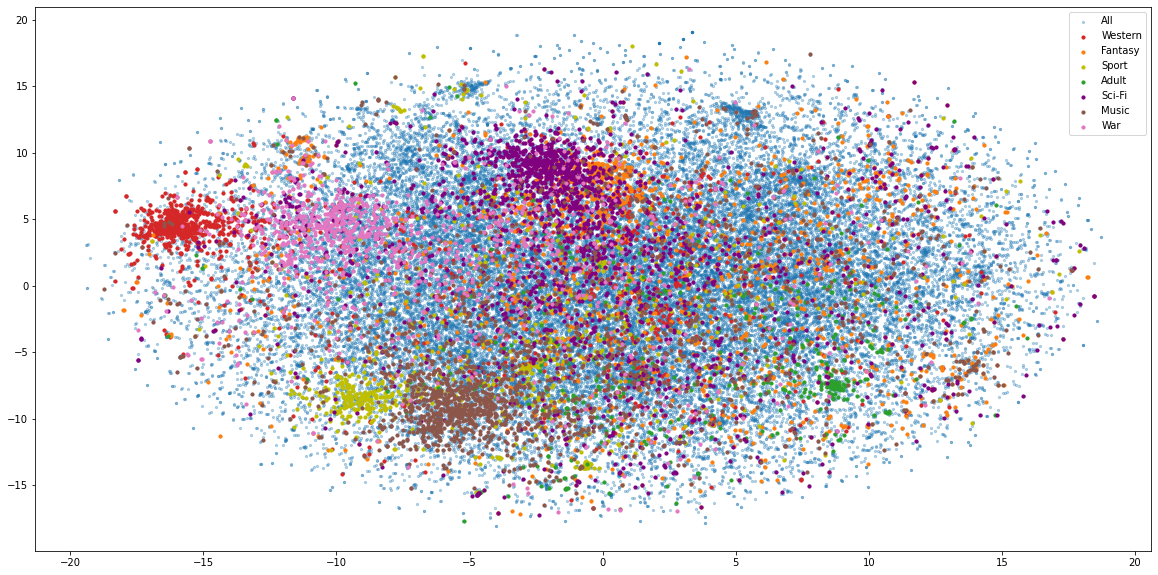

In [1170]:
genres = ['Western','Fantasy','Sport','Adult','Sci-Fi','Music','War']
colors = ["tab:red", "tab:orange", "y","tab:green", "purple", "tab:brown", "tab:pink","springgreen",'navy','gold']

plt.figure(figsize=(20,10))
plt.scatter(df_tsne['x'], df_tsne['y'], s=5, alpha=0.3,color='tab:blue',label='All')
for genre, color in zip(genres, colors):
    temp_df = df_tsne[df_tsne.genre.str.contains(genre)]
    plt.scatter(temp_df['x'],temp_df['y'],s=10,c=color, label=genre)
    
plt.legend()
plt.show()

In [1152]:
set([g.strip() for row in df.Genre for g in row.split(",")])

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Thriller',
 'War',
 'Western'}